# Installing and importing necessary libraries

In [1]:
!pip install torchao

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 71.2 MB/s eta 0:00:00


In [33]:
import copy
import torch
import torch.nn as nn
import torchvision
import torchao
import torch.optim as optim
import torch.quantization as tq
import torchvision.transforms as transforms
from torchao.quantization import quantize_, int8_dynamic_activation_int8_weight, int4_weight_only, int8_weight_only

# Preparing the dataset, model, optimizer for PTQ

In [41]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408),
                         (0.2675, 0.2565, 0.2761))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408),
                         (0.2675, 0.2565, 0.2761))
])

# Load CIFAR-100 datasets
trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                         download=True, transform=transform_train)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                        download=True, transform=transform_test)

testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                         shuffle=False, num_workers=2)

classes = trainset.classes

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loading pre-trained VGG-11 model
model = torchvision.models.vgg11(pretrained=True)

# Modify the classifier to output 100 classes for CIFAR-100
model.classifier[6] = nn.Linear(4096, 100)

model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Finetuning and evaluating the VGG Model on CIFAR-100 Dataset for baseline accuracy

In [42]:
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    total = 0
    correct = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        if batch_idx % 100 == 0:
            print(f'Epoch: {epoch+1}, Batch: {batch_idx}, Loss: {running_loss / (batch_idx + 1):.3f}, '
                  f'Accuracy: {100. * correct / total:.3f}%')

Epoch: 1, Batch: 0, Loss: 5.274, Accuracy: 0.000%
Epoch: 1, Batch: 100, Loss: 3.670, Accuracy: 14.132%
Epoch: 1, Batch: 200, Loss: 3.228, Accuracy: 21.436%
Epoch: 1, Batch: 300, Loss: 2.971, Accuracy: 26.238%
Epoch: 2, Batch: 0, Loss: 2.286, Accuracy: 36.719%
Epoch: 2, Batch: 100, Loss: 2.113, Accuracy: 43.611%
Epoch: 2, Batch: 200, Loss: 2.093, Accuracy: 43.867%
Epoch: 2, Batch: 300, Loss: 2.058, Accuracy: 44.684%
Epoch: 3, Batch: 0, Loss: 1.896, Accuracy: 53.125%
Epoch: 3, Batch: 100, Loss: 1.779, Accuracy: 51.230%
Epoch: 3, Batch: 200, Loss: 1.781, Accuracy: 51.325%
Epoch: 3, Batch: 300, Loss: 1.784, Accuracy: 51.326%
Epoch: 4, Batch: 0, Loss: 1.490, Accuracy: 53.906%
Epoch: 4, Batch: 100, Loss: 1.627, Accuracy: 55.012%
Epoch: 4, Batch: 200, Loss: 1.611, Accuracy: 55.574%
Epoch: 4, Batch: 300, Loss: 1.615, Accuracy: 55.269%
Epoch: 5, Batch: 0, Loss: 1.417, Accuracy: 60.156%
Epoch: 5, Batch: 100, Loss: 1.457, Accuracy: 59.112%
Epoch: 5, Batch: 200, Loss: 1.458, Accuracy: 58.959%
Epoc

In [43]:
def test(model, testloader):

    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    acc = 100. * correct / total
    print(f'Test Accuracy: {acc:.3f}%')

    return acc

original_acc = test(model, testloader)

Test Accuracy: 57.930%


# Evaluating models for PTQ

In [44]:
model_fp16 = copy.deepcopy(model).to(torch.float16)

model_bf16 = copy.deepcopy(model).to(torch.bfloat16)

model_int8 = copy.deepcopy(model)
# quantize_(model_int8, int8_dynamic_activation_int8_weight())
quantize_(model_int8, int8_weight_only())
model_int8 = model_int8.to(device)


def quantize_to_int4(tensor):
    # Determine the scaling factor based on the range of int4 [-8, 7]
    scale = 7.0 / torch.max(torch.abs(tensor))
    # Scale and clamp the tensor to the int4 range, then round to integers
    tensor_quantized = torch.round(tensor * scale).clamp(-8, 7)
    # Rescale back to floating point for the simulated quantization effect
    tensor_dequantized = tensor_quantized / scale
    return tensor_dequantized

def apply_int4_ptq(model):
    for name, module in model.named_modules():
        if isinstance(module, nn.Linear) or isinstance(module, nn.Conv2d):
            module.weight.data = quantize_to_int4(module.weight.data)   # Quantize weights only to int4 (for fair comparison)
    return model

model_int4 = apply_int4_ptq(model).to(device)

In [45]:
def test_ptq(model, testloader,bitwidth):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, targets in testloader:

            if bitwidth in ['INT8', 'INT4']:
                inputs = inputs.to(device)
            elif bitwidth == 'FP16':
                inputs = inputs.to(device).half()
            elif bitwidth == 'BF16':
                inputs = inputs.to(device).to(torch.bfloat16)

            targets = targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    acc = 100. * correct / total
    print(f'{bitwidth} PTQ Test Accuracy: {acc:.3f}%')
    return acc

In [46]:
fp16_acc_1 = test_ptq(model_fp16, testloader, 'FP16')
bf16_acc_1 = test_ptq(model_bf16, testloader, 'BF16')
int8_acc_1 = test_ptq(model_int8, testloader, 'INT8')
int4_acc_1 = test_ptq(model_int4, testloader, 'INT4')

FP16 PTQ Test Accuracy: 57.950%
BF16 PTQ Test Accuracy: 57.970%
INT8 PTQ Test Accuracy: 57.930%
INT4 PTQ Test Accuracy: 34.890%


# Evaluating models for QAT

## **bf16 and fp16**

In [47]:
# Set up optimizer and device and other config
num_epochs_qat = 5  # Small number of epochs for demonstration, saving compute
learning_rate = 0.001

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_model_qat(model, optimizer, trainloader, num_epochs, input_dtype=None):
    for epoch in range(num_epochs):
        model.train()
        running_loss, total, correct = 0.0, 0, 0
        for batch_idx, (inputs, targets) in enumerate(trainloader):
            inputs, targets = inputs.to(device), targets.to(device)
            if input_dtype:
                inputs = inputs.to(input_dtype)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()


            if not input_dtype and batch_idx % 100 == 0:
                print(
                    f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx}], "
                    f"Loss: {running_loss / (batch_idx + 1):.4f}, "
                    f"Accuracy: {100. * correct / total:.2f}%"
                )
        if input_dtype:
          print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {running_loss:.4f}, Accuracy: {100 * correct / total:.2f}%")


def test_model_qat(model, testloader, input_dtype=None,quantization_type='float'):
    model.eval()
    total, correct = 0, 0
    with torch.no_grad():
        for inputs, targets in testloader:
            if quantization_type == 'int':
              inputs, targets = inputs.to("cpu"), targets.to("cpu")
            else:
              inputs, targets = inputs.to(device), targets.to(device)
              if input_dtype:
                  inputs = inputs.to(input_dtype)

            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    accuracy = 100. * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

In [48]:
#################### QAT for fp16 ####################
model_fp16_qat = copy.deepcopy(model).to(device).to(torch.float16)

optimizer_fp16 = optim.SGD(model_fp16_qat.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

# Specify input_dtype=torch.float16 to ensure inputs are in fp16
train_model_qat(model_fp16_qat, optimizer_fp16, trainloader, num_epochs_qat, input_dtype=torch.float16)

# Test the fp16 model with input_dtype=torch.float16
fp16_qat_acc = test_model_qat(model_fp16_qat, testloader, input_dtype=torch.float16)
print(f'FP16 QAT Test Accuracy: {fp16_qat_acc:.3f}%')

Epoch [1/5] - Loss: 552.9346, Accuracy: 60.04%
Epoch [2/5] - Loss: 473.3848, Accuracy: 64.94%
Epoch [3/5] - Loss: 447.7832, Accuracy: 66.69%
Epoch [4/5] - Loss: 429.3540, Accuracy: 67.87%
Epoch [5/5] - Loss: 411.8203, Accuracy: 68.96%
Test Accuracy: 62.720%
FP16 QAT Test Accuracy: 62.720%


In [49]:
#################### QAT for bf16 ####################
model_bf16_qat = copy.deepcopy(model).to(device).to(torch.bfloat16)

optimizer_bf16 = optim.SGD(model_bf16_qat.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

# Specify input_dtype=torch.bfloat16 to ensure inputs are in bf16
train_model_qat(model_bf16_qat, optimizer_bf16, trainloader, num_epochs_qat, input_dtype=torch.bfloat16)

# Test the bf16 model with input_dtype=torch.bfloat16
bf16_qat_acc = test_model_qat(model_bf16_qat, testloader, input_dtype=torch.bfloat16)
print(f'BF16 QAT Test Accuracy: {bf16_qat_acc:.3f}%')

#training time for bf16 is way more than training time for fp16

Epoch [1/5] - Loss: 567.5469, Accuracy: 59.13%
Epoch [2/5] - Loss: 482.9766, Accuracy: 64.35%
Epoch [3/5] - Loss: 460.2383, Accuracy: 65.95%
Epoch [4/5] - Loss: 435.6875, Accuracy: 67.26%
Epoch [5/5] - Loss: 423.6758, Accuracy: 68.46%
Test Accuracy: 62.260%
BF16 QAT Test Accuracy: 62.260%


## **int4 and int8**

In [51]:
# Data transformations and dataset loading
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        (0.5071, 0.4867, 0.4408),
        (0.2675, 0.2565, 0.2761)
    )
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        (0.5071, 0.4867, 0.4408),
        (0.2675, 0.2565, 0.2761)
    )
])

trainset = torchvision.datasets.CIFAR100(
    root='./data',
    train=True,
    download=True,
    transform=transform_train
)
testset = torchvision.datasets.CIFAR100(
    root='./data',
    train=False,
    download=True,
    transform=transform_test
)

num_epochs = num_epochs_qat

Files already downloaded and verified
Files already downloaded and verified


In [52]:
# Class to wrap the fp32 model to include QuantStub and DeQuantStub for in4 and int8 QAT
class QuantizedVGG11(nn.Module):
    def __init__(self, model_fp32):
        super(QuantizedVGG11, self).__init__()
        self.quant = tq.QuantStub()
        self.model = model_fp32
        self.dequant = tq.DeQuantStub()

    def forward(self, x):
        x = self.quant(x)
        x = self.model(x)
        x = self.dequant(x)
        return x

In [54]:
# Set up device and backend for int8 quantization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.quantized.engine = "fbgemm"

# Load and modify VGG-11 model for CIFAR-100
model_fp32 = torchvision.models.vgg11(pretrained=True)
model_fp32.classifier[6] = nn.Linear(4096, 100)

trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=128,
    shuffle=True,
    num_workers=2
)
testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=100,
    shuffle=False,
    num_workers=2
)

model = QuantizedVGG11(model_fp32).to(device)

# Custom QAT configuration with per_tensor_affine for compatibility with fbgemm
int8_qconfig = tq.QConfig(
    activation=tq.MinMaxObserver.with_args(
        quant_min=0,
        quant_max=255,
        dtype=torch.quint8,
        qscheme=torch.per_tensor_affine
    ),
    weight=tq.MinMaxObserver.with_args(
        quant_min=-128,
        quant_max=127,
        dtype=torch.qint8,
        qscheme=torch.per_tensor_affine
    )
)

# Apply the QAT configuration
model.qconfig = int8_qconfig
tq.prepare_qat(model, inplace=True)

# Training setup for QAT
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(
    model.parameters(),
    lr=learning_rate,
    momentum=0.9,
    weight_decay=5e-4
)

print("Starting QAT training for int8 model...")
train_model_qat(model, optimizer, trainloader, num_epochs)

# Move the model to CPU before conversion
model.to("cpu")
model.eval()

# Convert the model to a quantized version for int8 inference
quantized_model = tq.convert(model, inplace=False)

print("Testing int8 quantized model...")
int8_qat_accuracy = test_model_qat(quantized_model, testloader,quantization_type='int')

Starting QAT training for int8 model...
Epoch [1/5], Batch [0], Loss: 5.1389, Accuracy: 1.56%
Epoch [1/5], Batch [100], Loss: 4.2188, Accuracy: 7.86%
Epoch [1/5], Batch [200], Loss: 3.6796, Accuracy: 15.00%
Epoch [1/5], Batch [300], Loss: 3.3627, Accuracy: 19.74%
Epoch [2/5], Batch [0], Loss: 2.3641, Accuracy: 30.47%
Epoch [2/5], Batch [100], Loss: 2.2952, Accuracy: 38.30%
Epoch [2/5], Batch [200], Loss: 2.2729, Accuracy: 38.98%
Epoch [2/5], Batch [300], Loss: 2.2326, Accuracy: 39.94%
Epoch [3/5], Batch [0], Loss: 2.2355, Accuracy: 41.41%
Epoch [3/5], Batch [100], Loss: 1.9591, Accuracy: 46.18%
Epoch [3/5], Batch [200], Loss: 1.9490, Accuracy: 46.58%
Epoch [3/5], Batch [300], Loss: 1.9419, Accuracy: 46.72%
Epoch [4/5], Batch [0], Loss: 1.9125, Accuracy: 45.31%
Epoch [4/5], Batch [100], Loss: 1.7729, Accuracy: 49.61%
Epoch [4/5], Batch [200], Loss: 1.7722, Accuracy: 50.03%
Epoch [4/5], Batch [300], Loss: 1.7708, Accuracy: 50.20%
Epoch [5/5], Batch [0], Loss: 1.4718, Accuracy: 56.25%
Epo

In [21]:
# Set up device
device = torch.device("cpu")

trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=128,
    shuffle=True,
    num_workers=2
)

testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=100,
    shuffle=False,
    num_workers=2
)

# Load and modify VGG-11 model for CIFAR-100
model_fp32 = torchvision.models.vgg11(pretrained=True)
model_fp32.classifier[6] = nn.Linear(4096, 100)


model = QuantizedVGG11(model_fp32).to(device)  # Initialize on CPU

# Define custom QConfig for int4 using built-in observers
int4_qconfig = tq.QConfig(
    activation=tq.FakeQuantize.with_args(
        observer=tq.MinMaxObserver,
        quant_min=0,
        quant_max=15,  # For 4-bit unsigned int
        dtype=torch.quint8,
        qscheme=torch.per_tensor_affine
    ),
    weight=tq.FakeQuantize.with_args(
        observer=tq.PerChannelMinMaxObserver,
        quant_min=-8,
        quant_max=7,  # For 4-bit signed int
        dtype=torch.qint8,
        qscheme=torch.per_channel_symmetric
    )
)

# Apply the custom int4 qconfig
model.qconfig = int4_qconfig

# Prepare the model for QAT
tq.prepare_qat(model, inplace=True)

# Training setup
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(
    model.parameters(),
    lr=learning_rate,
    momentum=0.9,
    weight_decay=5e-4
)

print("Starting QAT training for int4 model...")
train_model_qat(model, optimizer, trainloader, num_epochs)

# Ensure model is on CPU for evaluation
model.eval()

print("Testing int4 quantized model...")
int4_qat_accuracy = test_model_qat(model, testloader)

#was taking much time (12 mins per epoch) , so ran the same model for 3 more epochs instead of restarting it and running for 5 epochs

Epoch [1/3], Batch [0], Loss: 4.5713, Accuracy: 1.56%
Epoch [1/3], Batch [100], Loss: 4.6125, Accuracy: 1.22%
Epoch [1/3], Batch [200], Loss: 4.6111, Accuracy: 1.19%
Epoch [1/3], Batch [300], Loss: 4.6108, Accuracy: 1.18%
Epoch [2/3], Batch [0], Loss: 4.6160, Accuracy: 0.00%
Epoch [2/3], Batch [100], Loss: 4.6028, Accuracy: 1.14%
Epoch [2/3], Batch [200], Loss: 4.6042, Accuracy: 1.16%
Epoch [2/3], Batch [300], Loss: 4.6039, Accuracy: 1.18%
Epoch [3/3], Batch [0], Loss: 4.6013, Accuracy: 0.00%
Epoch [3/3], Batch [100], Loss: 4.5993, Accuracy: 1.14%
Epoch [3/3], Batch [200], Loss: 4.6015, Accuracy: 1.15%
Epoch [3/3], Batch [300], Loss: 4.6008, Accuracy: 1.18%
Testing int4 quantized model...
Test Accuracy: 1.34%


# Visualizing

In [ ]:
# qat_accuracies = [fp16_qat_acc, bf16_qat_acc, int8_qat_acc, int4_qat_acc]
# ptq_accuracies = [fp16_acc, bf16_acc, int8_acc, int4_acc]

# baseline VGG11 accuracy on CIFAR 100 ... 58.53 (at 5 epochs)
# qat_accuracies = [61.38, 60.67, 31.23, 1.42]        #2 epochs quantization-aware-training
# ptq_accuracies = [58.54, 58.57, 58.56, 30.04]


# try 2
#baseline 57.930
# ptq_accuracies =  [57.950, 57.970, 57.930,  34.890]
# qat_accuracies = [ 62.720 , 62.260 , 36.64 , 1.34]        #5 epochs quantization-aware-training

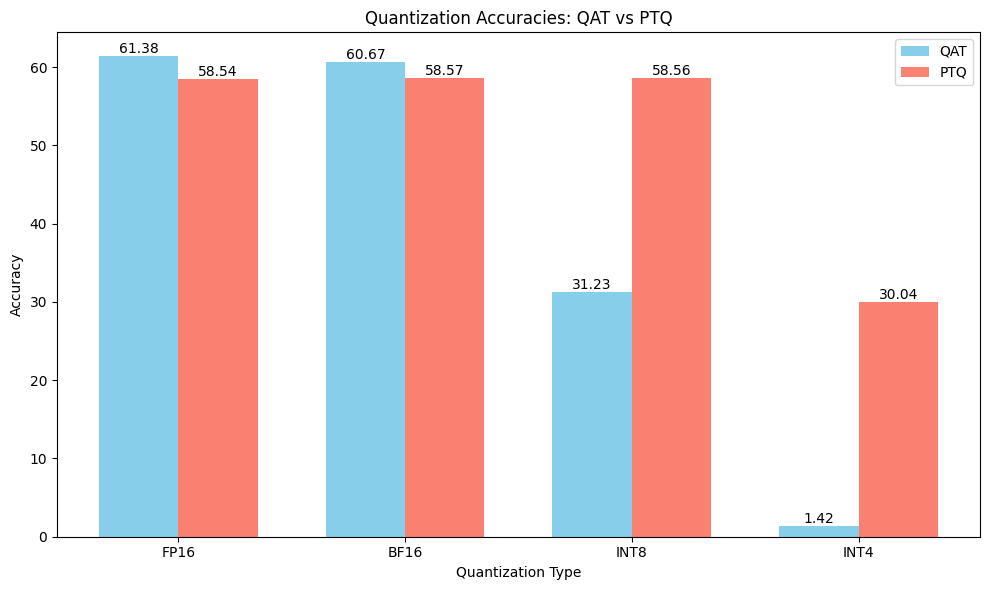

In [20]:
import matplotlib.pyplot as plt

def plot_quantization_accuracies(int8_qat_acc, int4_qat_acc, fp16_qat_acc, bf16_qat_acc,int8_acc, int4_acc, fp16_acc, bf16_acc):

    # Define accuracies for QAT and PTQ
    qat_accuracies = [fp16_qat_acc, bf16_qat_acc, int8_qat_acc, int4_qat_acc,]
    ptq_accuracies = [fp16_acc, bf16_acc, int8_acc, int4_acc]
    labels = ['FP16', 'BF16', 'INT8', 'INT4',]

    # Set up bar positions
    x = range(len(labels))
    width = 0.35  # Width for bars

    # Create plot
    plt.figure(figsize=(10, 6))

    # Plot QAT accuracies
    plt.bar(x, qat_accuracies, width, label='QAT', color='skyblue')

    # Plot PTQ accuracies offset slightly
    plt.bar([pos + width for pos in x], ptq_accuracies, width, label='PTQ', color='salmon')

    # Labels and title
    plt.xlabel('Bit Width')
    plt.ylabel('Model Accuracy')
    plt.title('Quantization Accuracies: QAT vs PTQ for varying bit-widths')
    plt.xticks([pos + width / 2 for pos in x], labels)  # Center labels
    plt.legend()

    # Display values on top of bars
    for i in range(len(qat_accuracies)):
        plt.text(x[i], qat_accuracies[i], f'{qat_accuracies[i]:.2f}', ha='center', va='bottom')
        plt.text(x[i] + width, ptq_accuracies[i], f'{ptq_accuracies[i]:.2f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

print("----------------------------------------->> QAT for 2 epochs")
plot_quantization_accuracies(int8_qat_accuracy, int4_qat_accuracy, fp16_qat_acc, bf16_qat_acc, int8_acc, int4_acc, fp16_acc, bf16_acc)

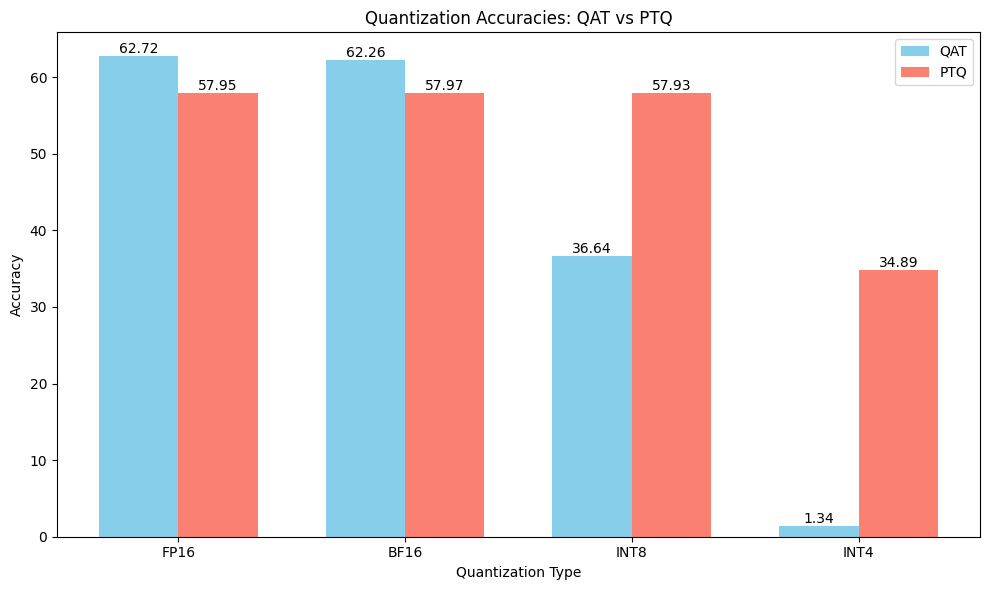

In [55]:
print("----------------------------------------->> QAT for 5 epochs")
plot_quantization_accuracies(int8_qat_accuracy, int4_qat_accuracy, fp16_qat_acc, bf16_qat_acc, int8_acc_1, int4_acc_1, fp16_acc_1, bf16_acc_1)